\title{Smets_Wouters}

\author{Laszlo Tetenyi}

\date{November 18, 2017}


\maketitle

\section*{State space representation}

In order to solve the problem, we first stack all the equations into canonical the canonical form:
\begin{equation*}
A(\theta)X_{t}=B(\theta)E_{t}X_{t+1}+C(\theta)X_{t-1}+D(\theta)\eta_{t}
\end{equation*}
where the state vector is the in deviation from the steady state:
\begin{equation*}
X_t =
\begin{bmatrix}
   y_t& c_t & i_t & g_t & l_t& k^s_t&z_t&k_t&\mu^p_t&\pi_t&r_t^k&\mu^w_t&w_t&r_t&\epsilon_t^a&\epsilon_t^b&\epsilon_t^g&\epsilon_t^i&\epsilon_t^r&\epsilon_t^p&\epsilon_t^w
\end{bmatrix}'
\end{equation*}
and the underlying parameters:
\begin{equation*}
\theta =
\begin{bmatrix}
   \tilde{\beta}& \bar{\pi}& \bar{l}&\alpha & \sigma &\Phi& \phi& h& \xi_w& \sigma_l& \xi_p&i_w&i_p&\psi& r_{\pi}&\rho&r_y\\
   r_{\Delta y}&\rho_{a}&\rho_{b}&\rho_{g}&\rho_{i}&\rho_{r}&\rho_{p}&\rho_{w}&\rho_{ga}&\mu_p&\mu_w&\sigma_a&\sigma_b&\sigma_g&\sigma_i&\sigma_r&\sigma_p&\sigma_w
\end{bmatrix}
\end{equation*}
Next we conjecture that the solution is linear:
\begin{equation*}
X_{t}=FX_{t-1}+G\eta_{t}
\end{equation*}\\
Since we can solve for $G$ once we know $F$. The $F$ matrix solves the following quadratic equation:
\begin{equation*}
BF^{2}-AF+C=0
\end{equation*}\\
We solve for $F$ using the Generalized Schur Decomposition. The observed variables $Y_{t}$ evolve according to: 
\begin{equation*}
Y_{t}= Const + H_1 X_{t} + H_2 X_{t-1} +J \zeta_{t}
\end{equation*}\\

In [1]:
import numpy as np
from numba import jit
import scipy.linalg as linalg
import scipy.stats as stats
import scipy.optimize as optimize
import matplotlib.pyplot as plt
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
from tqdm import tqdm
import quandl as Quandl
import pandas
import time
from matplotlib2tikz import save as tikz_save

True parameter vector is:

In [2]:
param_likely = np.array([0.159,0.774,-1.078,0.181,1.016,1.342,6.625,0.597,0.752,2.736,0.861,0.259,0.463,0.837,1.769,0.855,0.090,
                      0.168,0.982,0.868,0.962,0.702,0.414,0.782,0.971,0.450,0.673,0.892,0.375,0.073,0.428,0.35,0.144,0.101,0.311])

In [3]:
param_unlikely = np.array([0.182,0.571,0.019,0.23,1.166,1.455,4.065,0.511,0.647,1.217,0.807,0.452,0.494,0.828,1.827,0.836,0.069,
                    0.156,0.962,0.849,0.947,0.723,0.497,0.831,0.968,0.565,0.741,0.871,0.418,0.075,0.444,0.358,0.131,0.117,0.382])

In [4]:
#Model parameters that are calibrated
gamma_bar = 0.4312
delta = 0.025
lambda_w = 1.5
g_y = 0.18
epsilon_p = 10 # Kimball aggregator goods market
epsilon_w = 10 # Kimball aggregator labor market
no_st = 38
no_observables = 7

In [5]:
@jit
def eval_theta(param):
    #Parameters
    beta = 100/(param[0] + 100) 
    pi_bar = param[1]
    l_bar = param[2]
    alpha = param[3]
    sigma_c = param[4]
    Phi = param[5] 
    phi = param[6]
    h = param[7] 
    xi_w = param[8] 
    sigma_l= param[9]
    xi_p = param[10]
    i_w = param[11]
    i_p = param[12] 
    psi = param[13]
    r_pi = param[14] 
    rho = param[15] 
    r_y = param[16]
    r_Delta_y = param[17]
    rho_a = param[18] 
    rho_b = param[19] 
    rho_g = param[20] 
    rho_i = param[21] 
    rho_r = param[22] 
    rho_p = param[23] 
    rho_w = param[24] 
    rho_ga = param[25] 
    mu_p = param[26] 
    mu_w = param[27] 
    sigma_a = param[28] 
    sigma_b = param[29] 
    sigma_g = param[30] 
    sigma_i = param[31]
    sigma_r = param[32]
    sigma_p = param[33]
    sigma_w = param[34]
    gamma = gamma_bar/100 + 1
    star_pi = pi_bar /100 + 1
    r_bar = 100 * (1 /beta * gamma**sigma_c *star_pi - 1)
    r_k_ss = gamma**sigma_c/beta - 1 + delta
    w_ss = (alpha**alpha *(1 - alpha)**(1 - alpha)/(Phi * r_k_ss**(alpha)))**(1/(1 - alpha))
    i_k = (1 - (1 - delta)/gamma) * gamma
    l_k = (1 - alpha)/alpha * r_k_ss/ w_ss
    k_y = Phi * l_k**(alpha - 1)
    i_y = (gamma - 1 + delta) * k_y
    c_y = 1 - g_y - i_y
    z_y = r_k_ss * k_y
    wl_c = 1/lambda_w * (1 - alpha) /alpha * r_k_ss * k_y/c_y
    #Create DSGE matrix
    A = np.eye(no_st,no_st)
    B = np.zeros((no_st,no_st))
    C = np.zeros((no_st,no_st))
    D = np.zeros((no_st,no_observables))
    H = np.zeros((no_observables,no_st))
    J = np.eye(no_observables,no_observables)
    Const_obs = np.zeros((no_observables,1))
    # Load the model:
    #Output
    A[0,1] = -c_y
    A[0,2] = -i_y
    A[0,6] = -z_y
    A[0,16] = -1
    #Consumption
    A[1,4] = -wl_c * (sigma_c - 1)/sigma_c/(1 + h/gamma)
    A[1,13] = (1 - h/gamma)/(1 + h/gamma)/sigma_c
    A[1,15] = -1 #(1 - h/gamma)/(1 + h/gamma)/sigma_c
    B[1,4] = -wl_c * (sigma_c - 1)/sigma_c/(1 + h/gamma)
    B[1,9] = (1 - h/gamma)/(1 + h/gamma)/sigma_c
    B[1,1] = 1/(1 + h/gamma)
    C[1,1] = (h/gamma)/(1 + h/gamma)
    #Investment
    A[2,3] = -1/(gamma**2 * phi*(1 + beta * gamma**(1 - sigma_c)))
    B[2,2] = beta* gamma**(1-sigma_c) /(beta* gamma**(1-sigma_c) + 1)
    C[2,2] = 1 /(beta* gamma**(1-sigma_c) + 1)
    A[2,17] = -1
    #Arbitrage for the value of capital
    #A[3,15] = 1
    A[3,15] = -sigma_c* (h/gamma + 1) /(-h/gamma + 1)
    A[3,13] = 1
    B[3,3] = beta * (1-delta) * gamma**(-sigma_c)
    B[3,9] = 1
    B[3,10] = 1 - beta*(1 - delta)* gamma**(-sigma_c) 
    # Production - labor
    A[4,0] = 1
    A[4,5] = -Phi * alpha
    A[4,4] = -Phi * (1 - alpha)
    A[4,14] = -Phi
    # Effective Capital
    C[5,7] = 1
    A[5,6] = -1
    # Capital utilization
    A[6,10] = -(1 - psi)/psi
    # Installed capital
    A[7,2] =  - (1 - (1 - delta)/gamma)
    A[7,17] = - (1 - (1 - delta)/gamma) * phi * gamma**2 * (1 + beta * gamma**(1 - sigma_c))
    C[7,7] = (1 - delta)/gamma
    # Price mark-up
    A[8,5] = -alpha
    A[8,4] = alpha
    A[8,12] = 1
    A[8,14] = -1
    # New-Keynesian Phillips curve
    A[9,8] = ((1 - beta *gamma**(1 - sigma_c) * xi_p) * (1 - xi_p))/((
        1 + i_p *beta * gamma**(1 - sigma_c)) *  (1 + (Phi - 1)*epsilon_p)*xi_p)
    A[9,19] = -1
    B[9,9] = beta * gamma**(1 - sigma_c)/(1 + i_p * beta * gamma**(1 - sigma_c))
    C[9,9] = i_p/(1 + i_p* beta * gamma**(1 - sigma_c)) # typo in Schorfheide probably
    # Rental rate
    A[10,4] = -1
    A[10,12] = -1
    A[10,5] = 1
    #A[10,7] = 1 According to AEA original, but not to JPfeiffer or Schorfheide
    # Wage markup
    A[11,12] = -1
    A[11,4] = sigma_l
    A[11,1] = 1/ (1 - h/gamma)
    C[11,1] = h/gamma/ (1 - h/gamma)
    # Sticky wages
    A[12,9] = (1 + beta * gamma**(1 - sigma_c) * i_w)/(1 + beta * gamma**(1 - sigma_c))
    A[12,11] = ((1 - beta *gamma**(1 - sigma_c) * xi_w) * (1 - xi_w))/((
        1 + beta * gamma**(1 - sigma_c) )*  (1 + (lambda_w - 1)*epsilon_w)*xi_w)
    A[12,20] = -1
    B[12,12] = (beta * gamma**(1 - sigma_c))/(1 + beta * gamma**(1 - sigma_c))
    B[12,9] = (beta * gamma**(1 - sigma_c))/(1 + beta * gamma**(1 - sigma_c))
    C[12,12] = 1/(1 + beta * gamma**(1 - sigma_c))
    C[12,9] = i_w/(1 + beta * gamma**(1 - sigma_c)) # typo in Schorfheide probably
    # Nominal interest rate setting
    A[13,9] = -(1-rho)*r_pi
    A[13,0] = -(1-rho)*r_y - r_Delta_y
    A[13,21] = (1-rho)*r_y + r_Delta_y
    C[13,0] = - r_Delta_y
    C[13,21] =  r_Delta_y
    A[13,18] = -1
    C[13,13] = rho
    # Shocks
    C[14,14] = rho_a
    D[14,0] = sigma_a
    C[15,15] = rho_b
    D[15,1] = sigma_b
    C[16,16] = rho_g
    D[16,2] = sigma_g
    D[16,0] = rho_ga * sigma_a
    C[17,17] = rho_i
    D[17,3] = sigma_i
    C[18,18] = rho_r
    D[18,4] = sigma_r
    C[19,19] = rho_p
    D[19,5] = sigma_p # Temporary, for KF
    C[19,32] = -mu_p# Temporary, for KF
    C[20,20] = rho_w
    D[20,6] = sigma_w # Temporary, for KF
    C[20,33] = -mu_w# Temporary, for KF
    A[21,22] = -c_y
    A[21,23] = -i_y
    A[21,16] = -1
    A[21,27] = -z_y
    A[22,25] = -wl_c * (sigma_c - 1)/sigma_c/(1 + h/gamma)
    B[22,25] = -wl_c * (sigma_c - 1)/sigma_c/(1 + h/gamma)
    A[22,31] = (1 - h/gamma)/(1 + h/gamma)/sigma_c
    A[22,15] = -1 #(1 - h/gamma)/(1 + h/gamma)/sigma_c
    B[22,22] = 1/(1 + h/gamma)
    C[22,22] = (h/gamma)/(1 + h/gamma)
    A[23,24] = -1/(gamma**2 * phi*(1 + beta * gamma**(1 - sigma_c)))
    B[23,23] = beta* gamma**(1-sigma_c) /(beta* gamma**(1-sigma_c) + 1)
    C[23,23] = 1 /(beta* gamma**(1-sigma_c) + 1)
    A[23,17] = -1
    A[24,31] = 1
    #A[24,15] = 1
    A[24,15] = -sigma_c* (h/gamma + 1) /(-h/gamma + 1)
    B[24,24] = beta * (1-delta) * gamma**(-sigma_c)
    B[24,30] = 1 - beta*(1 - delta)* gamma**(-sigma_c) 
    A[25,21] = 1
    A[25,26] = -Phi * alpha
    A[25,25] = -Phi * (1 - alpha)
    A[25,14] = -Phi
    C[26,28] = 1
    A[26,27] = -1
    A[27,30] = -(1 - psi)/psi
    A[28,23] =  - (1 - (1 - delta)/gamma)
    A[28,17] = - (1 - (1 - delta)/gamma) * phi * gamma**2 * (1 + beta * gamma**(1 - sigma_c))
    C[28,28] = (1 - delta)/gamma
    A[29,26] = -alpha
    A[29,25] = alpha
    A[29,14] = -1
    A[30,25] = -1
    A[30,29] = -1
    A[30,26] = 1 # typo
    A[31,25] = -sigma_l
    A[31,22] = -1/(1 -h/gamma)
    A[31,29] = 1
    A[31,31] = 0
    C[31,22] = -h/gamma/(1 -h/gamma)
    # MA process 
    D[32,5] = sigma_p
    D[33,6] = sigma_w
    # Lagged observables stored as states:
    C[34,0] = 1
    C[35,1] = 1
    C[36,2] = 1
    C[37,12] = 1
    
    J[0,0] = 0.1731
    J[1,1] = 0.1394
    J[2,2] = 0.4515
    J[3,3] = 0.1128
    J[4,4] = 0.5838
    J[5,5] = 0.123
    J[6,6] = 0.1653
    
    H[0,0] = 1
    H[0,34] = -1
    Const_obs[0,0] = gamma_bar
    H[1,1] = 1
    H[1,35] = -1
    Const_obs[1,0] = gamma_bar
    H[2,2] = 1
    H[2,36] = -1
    Const_obs[2,0] = gamma_bar
    H[3,12] = 1
    H[3,37] = -1
    Const_obs[3,0] = gamma_bar
    H[4,4] = 1
    Const_obs[4,0] = l_bar
    H[5,9] = 1
    Const_obs[5,0] = pi_bar
    H[6,13] = 1
    Const_obs[6,0] = r_bar
    # Solve reduced form
    K = np.bmat([[np.zeros((no_st,no_st)), np.eye(no_st)], [-C, A]])
    L = np.bmat([[ np.eye(no_st),np.zeros((no_st,no_st))], [np.zeros((no_st,no_st)), B]])
    T,S,alppha,betta,Q,Z = linalg.ordqz(K,L,sort='iuc')
    Z = Z.T
    #print(1)
    #F = Z[(no_st):(2*no_st),0:no_st] @ linalg.inv(Z[0:no_st,0:no_st])
    if (linalg.det(Z[0:no_st,0:no_st]) != 0):
        F = (linalg.solve(Z[0:no_st,0:no_st],Z[0:no_st,(no_st):(2*no_st)])).T
        #print(2)
        #G = np.linalg.inv(A - (B @ F)) @ D
        if(linalg.det(A - (B @ F)) != 0):
            G = linalg.solve(A - (B @ F),D)
        else:
            F = np.eye(no_st)
            G = F
    else:
        F = np.eye(no_st)
        G = F
    err = B @ F @ F - A @ F + C 
    return F , G , H, J,Const_obs,err

In [6]:
%%timeit
F , G , H, J,Const_obs,err = eval_theta(param_likely)

6.14 ms ± 654 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
@jit
def KF_filter(F,G,H,J,x_obs,Const_obs):
    T = x_obs.shape[0]
    no_state = F.shape[0]
    no_measurement = J.shape[0]
    X = np.zeros((no_state,1))  # Number of state variables
    #P = np.mean(J.diagonal()) * np.zeros((no_state,no_state))  #Initial variance guess
    P = linalg.solve_discrete_lyapunov(F,G @ G.T)
    lnp = 0
    G_quad = G @ G.T
    J_quad = (J @ J.T)
    I_d = np.eye(no_measurement,no_measurement)
    for t in range(x_obs.shape[0]):
        X = F @ X
        P = F @ P @ F.T + G_quad
        y = x_obs[t,None].T - H @ X - Const_obs
        H_P_multi = H @ P
        V = H_P_multi @ H.T + J_quad
        inv_V = linalg.cho_solve(linalg.cho_factor(V,lower=True),I_d )
        #inv_V = linalg.inv(V)
        #print(linalg.det(P))
        lnp = lnp - 0.5 * (np.log(np.linalg.det(V)) + y.T @ inv_V @ y)
        X = X + P @ H.T @ inv_V @ y
        P = P - H_P_multi.T @ inv_V @ H_P_multi
    return lnp - 0.5 * T * no_measurement *  np.log(2*np.pi)  #With 2pi adjustment constant

In [8]:
def freq_likelihood(param,x_obs):
    F,G,H,J,Const_obs,err = eval_theta(param)
    eig_val,eig_vec = linalg.eig(F)
    if (np.all(np.absolute(eig_val) >=1)) ==0:
        res = KF_filter(F,G,H, J,x_obs,Const_obs)
    else:
        res = -np.inf
    return res

\section*{Datawork}


In [9]:
GDP = Quandl.get("FRED/GDPC1", authtoken="5QphWABG_zpJsB5dy4yW")
POP = Quandl.get("FRED/CNP16OV", authtoken="5QphWABG_zpJsB5dy4yW", collapse="quarterly")
POP = POP/ POP.values[178] # Normalization relative to 1992 Q3
CONS = Quandl.get("FRED/PCEC", authtoken="5QphWABG_zpJsB5dy4yW")
GDPP = Quandl.get("FRED/GDPDEF", authtoken="5QphWABG_zpJsB5dy4yW")
INV = Quandl.get("FRED/FPI", authtoken="5QphWABG_zpJsB5dy4yW")
W = Quandl.get("FRED/COMPNFB", authtoken="5QphWABG_zpJsB5dy4yW")
HOURS = Quandl.get("FRED/PRS85006023", authtoken="5QphWABG_zpJsB5dy4yW")
HOURS =HOURS/100
EMP = Quandl.get("FRED/CE16OV", authtoken="5QphWABG_zpJsB5dy4yW", collapse="quarterly")
EMP = EMP/ EMP.values[178] # Normalization relative to 1992 Q3
FFR = Quandl.get("FRED/FEDFUNDS", authtoken="5QphWABG_zpJsB5dy4yW", collapse="quarterly")

In [10]:
#x_obs = np.loadtxt("YY.txt",  delimiter='\t',dtype = None)
#np.double(x_obs)
#np.genfromtxt("YY.txt",delimiter='\t')

df = pandas.read_table("YY.txt",  delimiter=' ',header=None)
x_obs3 = df.values
x_obs3 = x_obs3[:,1:8]

In [11]:
t_start = 46
T = 180 - t_start + 23
scale = 100
x_obs = np.zeros((T,no_observables))
range_t_pop = range(t_start + 25,228)
range_t1_pop = range(t_start + 24,227)
range_t = range(t_start + 29,232)
range_t1 = range(t_start + 28,231)
range_int = range(202 - T,202)
x_obs[:,0] = scale * (np.log(GDP.values[range_t].flatten())
                      - np.log(POP.values[range_t_pop].flatten()) 
                      - np.log(GDP.values[range_t1].flatten())
                      + np.log(POP.values[range_t1_pop].flatten()))
x_obs[:,1] = scale * (np.log(CONS.values[range_t].flatten() )
                        - np.log(GDPP.values[range_t].flatten())
                        - np.log(POP.values[range_t_pop].flatten())
                        - np.log(CONS.values[range_t1].flatten())
                        + np.log(GDPP.values[range_t1].flatten()) 
                        + np.log(POP.values[range_t1_pop].flatten()))
x_obs[:,2] = scale * (np.log(INV.values[range_t].flatten()) 
                      - np.log( GDPP.values[range_t].flatten())
                      - np.log( POP.values[range_t_pop].flatten())  
                      - np.log(INV.values[range_t1].flatten()) 
                      + np.log(GDPP.values[range_t1].flatten()) 
                      + np.log(POP.values[range_t1_pop].flatten()))
x_obs[:,3] = scale * (np.log(W.values[range_t].flatten()) 
                             - np.log(GDPP.values[range_t].flatten())
                             - np.log(W.values[range_t1].flatten()) 
                             + np.log(GDPP.values[range_t1].flatten()))
x_obs[:,4] = scale * ( np.log(HOURS.values[range_t].flatten() 
                              + np.log( EMP.values[range_t_pop].flatten()) 
                              - np.log(POP.values[range_t_pop].flatten())))
x_obs[:,4] = x_obs[:,4] - x_obs[:,4].mean() 
x_obs[:,5] = scale * (np.log(GDPP.values[range_t].flatten()) - np.log(GDPP.values[range_t1].flatten()))
x_obs[:,6] = FFR.values[range_int].flatten()/4
x_obs2 = x_obs.copy()

In [12]:
#Simulation section:
T = 156
x = np.zeros((no_st,T)) 
v = np.random.randn(no_observables,T)
F , G, H, J, Const_obs,err= eval_theta(param_likely)
P_start = linalg.solve_discrete_lyapunov(F,G @ G.T)
for t in range(T-1):
    x[:,t + 1] = F @ x[:,t] + G @ v[:,t + 1]
x_obs = np.zeros((T,no_observables))
for t in range(T):
    x_obs[t,:] = H @ x[:,t] + J @ v[:,t] + Const_obs.T
KF_filter(F,G,H, J,x_obs,Const_obs)

array([[-970.0618776]])

In [13]:
F , G, H, J, Const_obs,err= eval_theta(param_likely)
KF_filter(F,G,H, J,x_obs3,Const_obs)

array([[-943.3407277]])

In [14]:
F , G, H, J, Const_obs,err= eval_theta(param_unlikely)
KF_filter(F,G,H, J,x_obs3,Const_obs)

array([[-956.11810844]])

In [15]:
#Notes at: https://www.dropbox.com/home/Econometrics%20Notes?preview=nyu_Bayes5_2017.pdf
def particle_filter(F,G,H,J,x_obs,Const_obs,no_simu = 10000):  #F,G,H,J matrix from Kalman filter computation
    T = x_obs.shape[0]
    no_state = F.shape[0]
    no_measurement = J.shape[0]
    X_mean = np.zeros((no_st,1)) #Initialize the particle cloud at 0
    V_x = linalg.solve_discrete_lyapunov(F,G @ G.T) #Initial Variance function solved from FVF'−F+G @ G.T=0
    P = V_x #+ 10 * np.eye(no_state,no_state) # P matrix is the initial variance
    lnp = 0 # Initialize likelihood value
    #Eta = np.reshape(random_sample(np.zeros(no_state), G @ G.T,no_simu*T),(T,no_simu,no_state),order='F') 
    Eta = np.reshape(np.random.multivariate_normal(np.zeros(no_state), G @ G.T,no_simu*T),(T,no_simu,no_state),order='F') 
    #Eta shock reshaped for the number similutaion and time periods, ordered by Fortran optimal code
    X = np.random.multivariate_normal(X_mean.flatten(),P,no_simu) #Initial X draw
    p_yx = np.zeros((X.shape[0]))
    Var_y = J @ J.T
    inv_Var_y = linalg.inv(Var_y)
    const_obs = np.tile(Const_obs.T,(no_simu,1))
    for t in range(T): #Loop over time periods and add up the likelihood
        X_next = X @ F.T + Eta[t,:,:]             #Propagate the paricle forward
        y_dev = x_obs[t,:] -X_next @ H.T - const_obs
        p_yx = np.exp( -0.5 * (np.log(np.linalg.det(Var_y)) + np.diag(( y_dev) @ inv_Var_y @ (y_dev).T))) 
        #Computing the likelihoood
        p_yy = p_yx.mean()
        lnp = np.log(p_yy) + lnp
        weights_val = p_yx/p_yy/no_simu #Giving weights to the observations
        multisample = np.random.multinomial(no_simu, weights_val.flatten(), size=1).flatten() #resampling based on weights
        X_next = np.repeat(X_next,multisample,axis = 0) #Creating a new sample based on the weights
        X = X_next.copy()
    return lnp - 0.5 * T * no_measurement *  np.log(2*np.pi)

In [16]:
particle_filter(F,G,H,J,x_obs3,Const_obs,no_simu = 2000)

-1758.0710063366582

In [17]:
def tempered_particle_filter(F,G,H,J,x_obs,Const_obs,no_simu,r_star = 2,phi_init = 0.2,markov_time = 1): 
    T = x_obs.shape[0]
    no_state = F.shape[0]
    no_measurement = J.shape[0]
    X_mean = np.zeros((no_st,1)) #Initialize the particle cloud at 0
    V_x = linalg.solve_discrete_lyapunov(F,G @ G.T) #Initial Variance function solved from FVF'−F+G @ G.T=0
    P = V_x# + 10 * np.eye(5,5) # P matrix is the initial variance
    lnp = 0 # Initialize likelihood value
    Eta = np.reshape(np.random.multivariate_normal(np.zeros(no_measurement), np.eye(no_measurement),no_simu*T),(T,no_simu,no_measurement),order='F') 
    X =  np.random.multivariate_normal(X_mean.flatten(),P,no_simu)
    p_yx = np.zeros((X.shape[0]))
    const_obs = Const_obs.T
    Var_y = J @ J.T
    Var_eps = G @ G.T 
    inv_Var_y = linalg.inv(Var_y)
    maxiter = 30 # max number of iterations in the while loop
    accept_shock = np.random.uniform(size = (markov_time,no_simu,T,maxiter))
    mutate_shock = np.reshape(np.random.multivariate_normal(np.zeros(no_measurement),np.eye(no_measurement),no_simu*T*maxiter*markov_time
                                           ),(T,no_simu,no_measurement,maxiter,markov_time),order='F')
    def eval_weights(phi,phi_prev,e_dev):
        return np.exp(-e_dev*(phi-phi_prev))*(phi/phi_prev)**(no_measurement/2)
    def eval_inef_ratio(phi,phi_prev,e_dev,r_star):
        eval_weights_tmp = eval_weights(phi,phi_prev,e_dev)
        return np.sum((eval_weights_tmp/eval_weights_tmp.mean())**2)/no_simu -r_star
    def eval_inef_ratio_init(phi,r_star,no_simu,e_dev):
        A1=(2 * np.pi)**(-no_measurement/2) *  np.exp(- phi* e_dev) * (np.linalg.det(inv_Var_y*phi))**(1/2)
        B1=A1.mean()
        return np.sum((A1/B1)**2)/no_simu - r_star
    def eval_weights_avg(eval_weights_tmp):
        return eval_weights_tmp/ np.mean(eval_weights_tmp)/no_simu
    def c_var_updater_mh(x):
        return 0.95 + 0.1 * np.exp(20 * (x-0.4))/(1 + np.exp(20 * (x-0.4)))
    
    for t in range(T): #Loop over time periods and add up the likelihood
        #print(t)
        #const_obs = 0
        c_var = 0.3
        #phi_tmp1 = phi_init
        #phi_tmp2 = phi_init
        X_ft = X @ F.T
        X_next = X_ft + Eta[t,:,:] @ G.T           #Propagate the paricle forward
        #plt.hist(Eta[t,:,:])
        y_dev = x_obs[t,:] -X_next @ H.T - const_obs
        e_dev = 0.5 * np.diag(( y_dev) @ inv_Var_y @ (y_dev).T)
        phi_init1 = optimize.bisect(eval_inef_ratio_init,phi_init,1,args = (r_star,no_simu,e_dev))
        phi = phi_init1
        #print(phi)
        p_yx = np.exp(- phi* e_dev) * (np.linalg.det(inv_Var_y*phi))**(1/2)
        ##p_yx_true = np.exp( -0.5 * np.log(np.linalg.det(Var_y)) - e_dev) 
        #Computing the likelihoood
        p_yy = p_yx.mean()
        weights_val = p_yx/p_yy/no_simu #Giving weights to the observations
        multisample = np.random.multinomial(no_simu, weights_val.flatten(), size=1).flatten() #resampling based on weights
        X_next = np.repeat(X_next,multisample,axis = 0) 
        X = np.repeat(X,multisample,axis = 0)#Creating a new sample based on the weights
        Eta_mutate = np.repeat(Eta[t,:,:] ,multisample,axis = 0)#Creating a new sample based on the weights
        #X = X_next_sample.copy()
        iterate = 0
        lnp = np.log(p_yx.mean()) + lnp - 0.5 * no_measurement *  np.log(2*np.pi)
        #print(np.log(p_yx.mean()))
        while (phi <1):
        #while (iterate < 0):
            #print(iterate,phi,lnp)
            #print(phi,phi_tmp1,phi_tmp2)
            y_dev = x_obs[t,:] -X_next @ H.T - const_obs
            e_dev = 0.5 * np.diag(( y_dev) @ inv_Var_y @ (y_dev).T)
            if(eval_inef_ratio(1,phi,e_dev,r_star) <= 0):
                weights_lik = eval_weights(1,phi,e_dev)
                #phi_prev = phi
                phi = 1
            else:
                phi_tmp = optimize.bisect(eval_inef_ratio,phi,1,args = (phi,e_dev,r_star))
                weights_lik = eval_weights(phi_tmp,phi,e_dev)
                phi = phi_tmp 
            weights_val = eval_weights_avg(weights_lik)
            multisample = np.random.multinomial(no_simu, weights_val.flatten(), size=1).flatten() #resampling based on weights
            X_next = np.repeat(X_next,multisample,axis = 0) 
            X = np.repeat(X,multisample,axis = 0)#Creating a new sample based on the weights
            Eta_mutate = np.repeat(Eta_mutate ,multisample,axis = 0)#Creating a new sample based on the weight           
            for mt in range(markov_time):
                X_ft = X @ F.T
                Eta_mutate_tmp = Eta_mutate + c_var * mutate_shock[t,:,:,iterate,mt]
                X_next_mt_sample = X_ft + Eta_mutate_tmp @ G.T          #Propagate the paricle forward
                y_dev_mt_sample = x_obs[t,:] -X_next_mt_sample @ H.T - const_obs
                e_dev_mt_sample = 0.5 * np.diag(( y_dev_mt_sample) @ ( inv_Var_y) @ (y_dev_mt_sample).T)
                p_yx_tmp =  - phi* e_dev_mt_sample
                y_dev_mt_past = x_obs[t,:] -X_next @ H.T - const_obs
                e_dev_mt_past = 0.5 * np.diag(( y_dev_mt_past) @ (  inv_Var_y) @ (y_dev_mt_past).T)
                p_yx_past =  -  phi* e_dev_mt_past
                pr_ratio = -0.5 * np.sum(Eta_mutate_tmp**2 -Eta_mutate**2,1)
                acceptance_rate = np.exp( p_yx_tmp - p_yx_past+pr_ratio)
                decision = acceptance_rate > accept_shock[mt,:,t,iterate]
                tiled_decision = np.tile(decision,(no_measurement,1)).T
                tiled_decision_x = np.tile(decision,(no_state,1)).T
                Eta_mutate = Eta_mutate_tmp * tiled_decision + (1 - tiled_decision) * Eta_mutate
                X_next = X_next_mt_sample * tiled_decision_x + (1 - tiled_decision_x) * X_next
            c_var = c_var * c_var_updater_mh(decision.sum()/no_simu)
            iterate = iterate +1
            lnp = np.log(np.mean(weights_lik))  + lnp
        X = X_next.copy()
    return lnp 

In [24]:
tempered_particle_filter(F,G,H,J,x_obs3,Const_obs,6000,r_star = 2,phi_init = 0.002,markov_time = 1)

-1066.3491780438794

In [19]:
no_runs = 20
likelihood_val = np.zeros((no_runs,2))
F , G, H, J, Const_obs,err= eval_theta(param_likely)
KF_filter(F,G,H, J,x_obs3,Const_obs)
for i in tqdm(range(no_runs)):
    t0 = time.time()
    likelihood_val[i,0] = particle_filter(F,G,H,J,x_obs3,Const_obs,no_simu = 40000)
    t1 = time.time()
    likelihood_val[i,1] = t1-t0
    np.savetxt("lnp_bspf_param_likely.csv", likelihood_val, delimiter=",")
Bias = np.mean(likelihood_val[:,0])
StDev = np.std(likelihood_val[:,0])
AvgTime = np.mean(likelihood_val[:,1])
print(Bias, StDev,AvgTime)

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [5:05:28<00:00, 916.41s/it]


-1212.74955884 81.9596633676 916.382418597


In [20]:
no_runs = 20
likelihood_val = np.zeros((no_runs,2))
F , G, H, J, Const_obs,err= eval_theta(param_unlikely)
KF_filter(F,G,H, J,x_obs3,Const_obs)
for i in tqdm(range(no_runs)):
    t0 = time.time()
    likelihood_val[i,0] = particle_filter(F,G,H,J,x_obs3,Const_obs,no_simu = 40000)
    t1 = time.time()
    likelihood_val[i,1] = t1-t0
    np.savetxt("lnp_bspf_param_unlikely.csv", likelihood_val, delimiter=",")
Bias = np.mean(likelihood_val[:,0])
StDev = np.std(likelihood_val[:,0])
AvgTime = np.mean(likelihood_val[:,1])
print(Bias, StDev,AvgTime)

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [5:04:22<00:00, 913.13s/it]


-1223.46248238 61.3549436589 913.11138916


In [23]:
lnp_BSPF[:,0].std()

81.959663367589727

In [29]:
df2 = pandas.read_table("lnp.csv",  delimiter=',',header=None)
lnp_TPF = df2.values

In [37]:
lnp_TPF[0:16,0].mean()

-1667.2304599712243

In [25]:
no_runs = 100
likelihood_val = np.zeros((no_runs,2))
F , G, H, J, Const_obs,err= eval_theta(param_likely)
KF_filter(F,G,H, J,x_obs3,Const_obs)
for i in tqdm(range(no_runs)):
    t0 = time.time()
    likelihood_val[i,0] = tempered_particle_filter(F,G,H,J,x_obs3,Const_obs,8000,r_star = 2,phi_init = 0.0002,markov_time = 1)
    t1 = time.time()
    likelihood_val[i,1] = t1-t0
    np.savetxt("lnp_tpf_param_likely.csv", likelihood_val, delimiter=",")
Bias = np.mean(likelihood_val[:,0])
StDev = np.std(likelihood_val[:,0])
AvgTime = np.mean(likelihood_val[:,1])
print(Bias, StDev,AvgTime)

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [16:57:26<00:00, 610.47s/it]


-1064.62320011 42.5444166354 610.46795861


In [26]:
no_runs = 100
likelihood_val = np.zeros((no_runs,2))
F , G, H, J, Const_obs,err= eval_theta(param_unlikely)
KF_filter(F,G,H, J,x_obs3,Const_obs)
for i in tqdm(range(no_runs)):
    t0 = time.time()
    likelihood_val[i,0] = tempered_particle_filter(F,G,H,J,x_obs3,Const_obs,6000,r_star = 2,phi_init = 0.0002,markov_time = 1)
    t1 = time.time()
    likelihood_val[i,1] = t1-t0
    np.savetxt("lnp_tpf_param_unlikely.csv", likelihood_val, delimiter=",")
Bias = np.mean(likelihood_val[:,0])
StDev = np.std(likelihood_val[:,0])
AvgTime = np.mean(likelihood_val[:,1])
print(Bias, StDev,AvgTime)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [9:37:09<00:00, 346.29s/it]


-1112.97964019 45.0535955136 346.29032063


In [19]:
df_bspf_param_likely = pandas.read_table("lnp_bspf_param_likely.csv",  delimiter=',',header=None)
df_bspf_param_unlikely = pandas.read_table("lnp_bspf_param_unlikely.csv",  delimiter=',',header=None)
df_tpf_param_likely = pandas.read_table("lnp_tpf_param_likely.csv",  delimiter=',',header=None)
df_tpf_param_unlikely = pandas.read_table("lnp_tpf_param_unlikely.csv",  delimiter=',',header=None)
F , G, H, J, Const_obs,err= eval_theta(param_likely)
df_bspf_param_likely.values[:,0] = df_bspf_param_likely[0].values  -  KF_filter(F,G,H, J,x_obs3,Const_obs)
df_tpf_param_likely.values[:,0] = df_tpf_param_likely[0].values  -  KF_filter(F,G,H, J,x_obs3,Const_obs)
F , G, H, J, Const_obs,err= eval_theta(param_unlikely)
df_bspf_param_unlikely.values[:,0] = df_bspf_param_unlikely[0].values  -  KF_filter(F,G,H, J,x_obs3,Const_obs)
df_tpf_param_unlikely.values[:,0] = df_tpf_param_unlikely[0].values  -  KF_filter(F,G,H, J,x_obs3,Const_obs)

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter


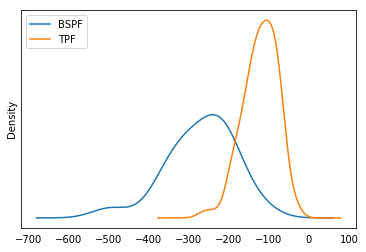

In [20]:
df_bspf_param_likely[0].plot.density()
df_tpf_param_likely[0].plot.density()
plt.legend(['BSPF', 'TPF'], loc='upper left')
plt.tick_params(
    axis='both',          # changes apply to the x-axis\n",
    which='both',      # both major and minor ticks are affected\n",
    bottom='off',      # ticks along the bottom edge are off\n",
    top='off',         # ticks along the top edge are off\n",
    left = 'off',
    right = 'off',
    #labelbottom='off',# labels along the bottom edge are off\n",
    labelleft='off')
tikz_save('SW_likely.tikz')

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter


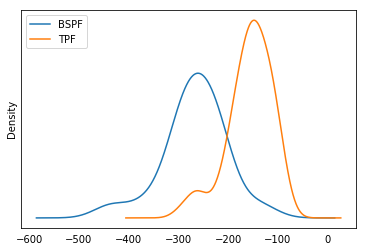

In [21]:
df_bspf_param_unlikely[0].plot.density()
df_tpf_param_unlikely[0].plot.density()
plt.legend(['BSPF', 'TPF'], loc='upper left')
plt.tick_params(
    axis='both',          # changes apply to the x-axis\n",
    which='both',      # both major and minor ticks are affected\n",
    bottom='off',      # ticks along the bottom edge are off\n",
    top='off',         # ticks along the top edge are off\n",
    left = 'off',
    right = 'off',
    #labelbottom='off',# labels along the bottom edge are off\n",
    labelleft='off')
tikz_save('SW_unlikely.tikz')